### Import Section

In [1]:
# import necessay modules
import numpy as np
import torch
import torchinfo
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
from torch.utils.data import Dataset, DataLoader # Gives easier dataset managment by creating mini batches etc.
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from tqdm import tqdm # for nice loading
import matplotlib.pyplot as plt
import os
import itertools

### Config Section

In [2]:
# device config
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Hyper Parameter

In [3]:
NUM_WORKERS = 2
BATCH_SIZE = 64
PIN_MEMORY = True
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_PATH = "checkpoints/mnist_checkpoint.pth.tar"
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
VALID_SIZE= .2

### Data Processing Section

In [4]:
def get_dataloader(batch_size, num_workers=0):

    # percentage of training set to use as validation
    valid_size = 0.2

    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )

    test_data = datasets.MNIST(
        root="./data", train=False, download=True, transform=transform
    )

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
    )

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
    )

    # load test data in batches
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, num_workers=num_workers
    )

    return train_loader, test_loader, valid_loader

### Data visalization

In [5]:
## Visualize data
def plot_dataset(data_loader):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images = images.numpy()

    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        # print out the correct label for each image
        ax.set_title(str(labels[idx].item()))

    plt.show()  

In [6]:
def plot_single_data(data_loader):
    dataiter = iter(data_loader)
    images, _ = next(dataiter)
    images = images.numpy()
    img = np.squeeze(images[1])

    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

In [7]:
def plot_confusion_matrix(confusion_matrix):

    # Convert to numpy array
    confusion_matrix = confusion_matrix.numpy()

    # Create a figure and axis to plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Define the class labels for MNIST (digits 0-9)
    classes = [str(i) for i in range(10)]

    # Set ticks for the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add labels and values in each cell
    thresh = confusion_matrix.max() / 2
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], '.0f'),
                horizontalalignment="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [8]:
def plot_loss(train_loss, valid_loss):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 0.5) # consistent scale
    plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('loss_plot.png', bbox_inches='tight')

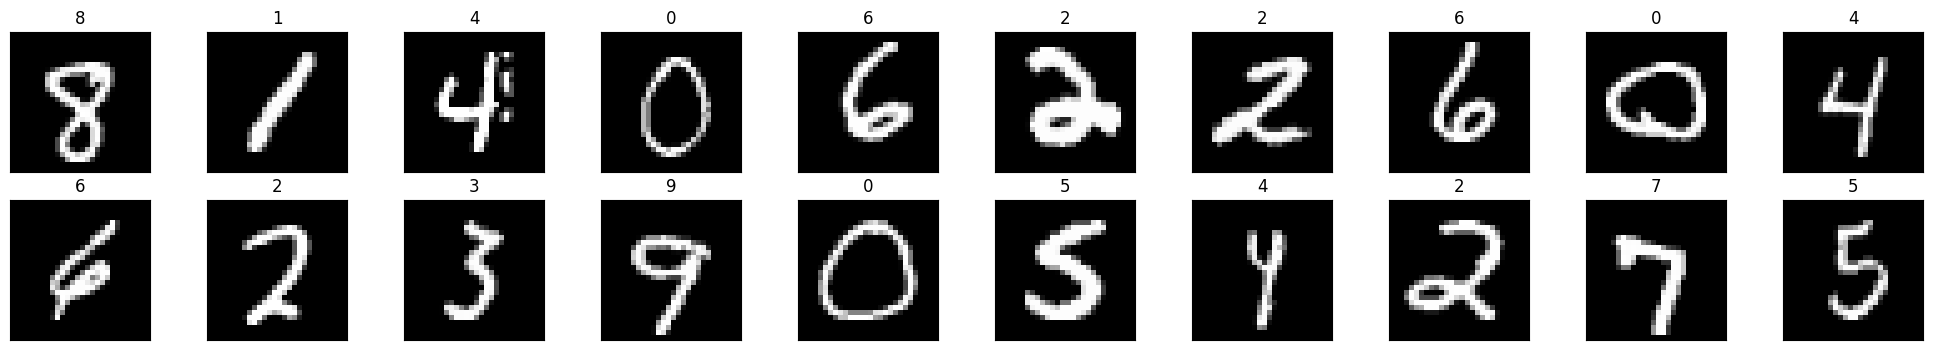

In [9]:
train_loader, test_loader, valid_loader = get_dataloader(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
plot_dataset(train_loader)

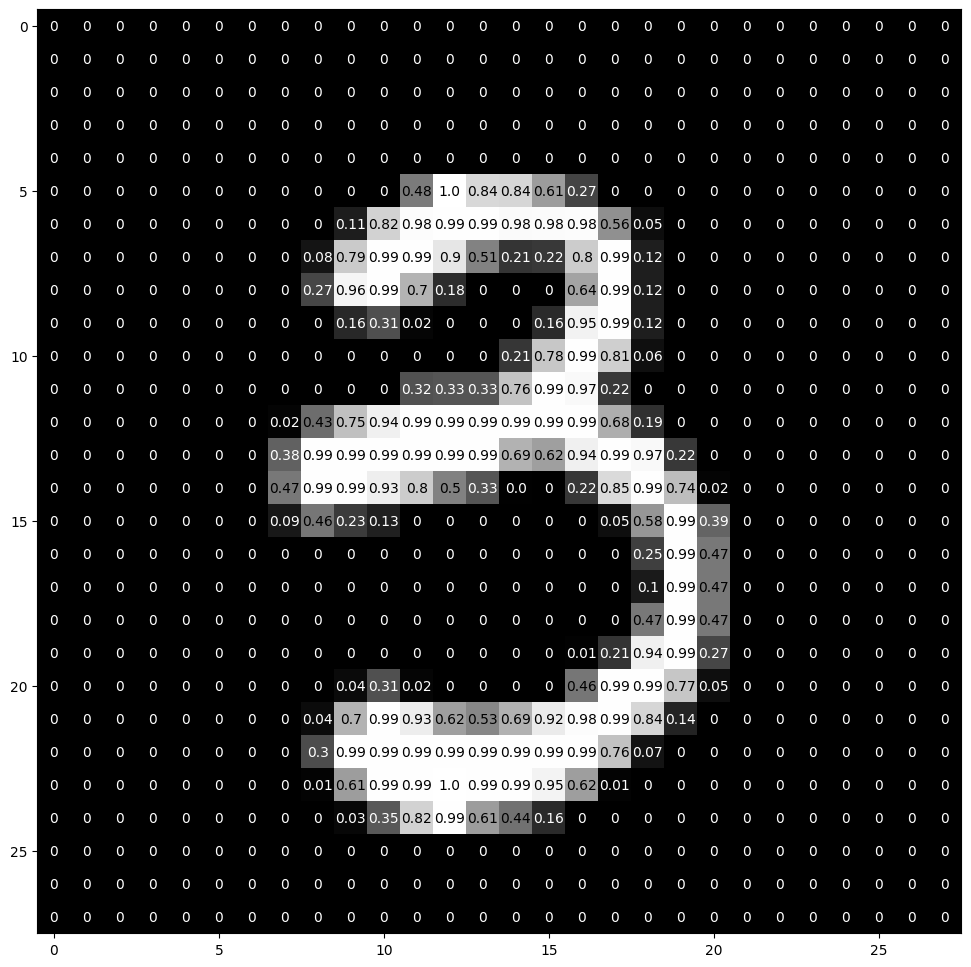

In [10]:
plot_single_data(train_loader)

### Simple CNN architecture

In [11]:
class CNNNet(nn.Module):
    def __init__(self, in_channels =1, num_classes=10):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels= 8, kernel_size=(3,3),stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels= 16, kernel_size=(3,3),stride=(1,1), padding=(1,1))
        self.fc1 = nn.Linear(16*7*7, num_classes)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return x

### Utils section

In [12]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = torch.sum(preds == labels).item()
    total = labels.size(0)
    accuracy= correct / total
    return accuracy , correct, total

In [13]:
def precision_recall_f1(outputs, labels, num_classes=10):
    TP = torch.zeros(num_classes)
    FP = torch.zeros(num_classes)
    FN = torch.zeros(num_classes)
    
    _, preds = torch.max(outputs, 1)
    
    for i in range(num_classes):
        TP[i] = torch.sum((preds == i) & (labels == i)).item()
        FP[i] = torch.sum((preds == i) & (labels != i)).item()
        FN[i] = torch.sum((preds != i) & (labels == i)).item()

    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    avg_precision = precision.mean().item()
    avg_recall = recall.mean().item()
    avg_f1 = f1.mean().item()
    
    return avg_precision, avg_recall, avg_f1

In [14]:
def confusion_matrix(outputs, labels, num_classes=10):
    _, preds = torch.max(outputs, 1)
    cm = torch.zeros(num_classes, num_classes)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1
    
    return cm

#### Saving and Loading Model

In [15]:
def save_checkpoint(filepath, model, optimizer, train_acc, train_loss, epoch):
    save_state = {
        "state_dict": model.state_dict(),
        "epoch": epoch,
        "optimizer": optimizer.state_dict(),
        "loss": train_loss,
        "acc": train_acc,
    }
    print()
    print("Saving current parameters")
    print("___________________________________________________________")

    torch.save(save_state, filepath)

In [16]:
def load_model(filepath, model, optimizer):
    start_epoch = 1  # Initialize start_epoch to 1
    best_acc = 0.0   # Initialize best accuracy to 0
    valid_loss_min = np.Inf  # Initialize the best validation loss to infinity
    
    if filepath and os.path.isfile(filepath):
           
        print("=> loading checkpoint")
        checkpoint = torch.load(filepath)
        start_epoch = checkpoint["epoch"]
        best_acc = checkpoint["acc"]
        valid_loss_min = checkpoint["loss"]
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        print(
            "=> loaded checkpoint (epoch {})".format(
                checkpoint["epoch"]
            )
        )
    else:
        print("No pretrained model. Starting from scratch!")
    
    return model, optimizer, start_epoch, best_acc, valid_loss_min

In [17]:
def check_accuracy(model, device, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_outputs = []
    all_labels = []
    valid_loss = 0.0
    n=len(test_loader)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)

            loss = criterion(outputs, target)
            valid_loss += loss.item()

            # Accumulate predictions and labels
            all_outputs.append(outputs)
            all_labels.append(target)

            # Calculate accuracy for the current batch
            correct += (outputs.argmax(1) == target).sum().item()
            total += target.size(0)

    # Convert list of tensors to single tensor
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Accuracy
    acc = correct / total
    # print(f'Accuracy: {acc * 100:.2f}%')

    # Precision, Recall, F1-Score
    precision, recall, f1 = precision_recall_f1(all_outputs, all_labels, num_classes=10)
    # print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(all_outputs, all_labels, num_classes=10)
    # print(f'Confusion Matrix:\n{cm}')

    valid_loss=valid_loss/n 

    return acc, precision, recall, f1, cm, valid_loss

### Loss Function and Optimizer

In [18]:
model= CNNNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

### Train Network

In [19]:
def train_network(model, optimizer, n_epochs, train_loader, valid_loader, filepath=CHECKPOINT_PATH):

    train_loss = 0.0
    avg_train_losses = []
    avg_valid_losses = []
    avg_train_acc = []
    avg_valid_acc = []
    total=len(train_loader)

    model, optimizer, start_epoch, best_acc, valid_loss_min = load_model(filepath=filepath, model=model, optimizer=optimizer)

    for epoch in range(start_epoch, n_epochs + 1):

        model.train()
        correct_train = 0
        total_train = 0
        
        for batch, (data, target) in enumerate(tqdm(train_loader), 1):

            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)  # calculate the loss

            loss.backward()  # backward pass: compute gradient of the loss with respect to model parameters

            optimizer.step()  # perform a single optimization step (parameter update)

            # record training loss
            train_loss+=loss.item()

            # Calculate training accuracy
            _, correct_batch, total_batch = calculate_accuracy(output, target)
            correct_train += correct_batch
            total_train += total_batch

        # validate the model
        valid_accuracy, precision, recall, f1, cm, valid_loss = check_accuracy(model=model, device=device, test_loader=valid_loader, criterion=criterion)
        

        # calculate average loss, accuracy over an epoch
        train_loss = train_loss/total


        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

         # Calculate and store training accuracy
        train_accuracy = 100 * correct_train / total_train
        avg_train_acc.append(train_accuracy)

        # Calculate and store validation accuracy
        avg_valid_acc.append(valid_accuracy)
       

        epoch_len = len(str(n_epochs))

        print_msg = (f"[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] "
                     f"train_loss: {train_loss:.5f} "
                     f"train_acc: {train_accuracy:.2f}% "
                     f"valid_loss: {valid_loss:.5f} "
                     f"valid_acc: {valid_accuracy:.2f}%")

        print(print_msg)

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(
                "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                    valid_loss_min, valid_loss
                )
            )
            save_checkpoint(filepath=filepath,model=model, optimizer=optimizer,train_acc=valid_accuracy, train_loss=valid_loss, epoch=epoch)
            valid_loss_min = valid_loss

    return model, avg_train_losses, avg_valid_losses

In [20]:
model, train_loss, valid_loss = train_network(model, optimizer, NUM_EPOCHS, train_loader, valid_loader)

=> loading checkpoint
=> loaded checkpoint (epoch 3)


100%|██████████| 750/750 [00:22<00:00, 33.63it/s]


[ 3/50] train_loss: 0.15390 train_acc: 95.61% valid_loss: 0.15957 valid_acc: 0.95%


100%|██████████| 750/750 [00:14<00:00, 50.06it/s]


[ 4/50] train_loss: 0.15167 train_acc: 95.65% valid_loss: 0.15590 valid_acc: 0.95%
Validation loss decreased (0.157551 --> 0.155900).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:31<00:00, 24.12it/s]


[ 5/50] train_loss: 0.14926 train_acc: 95.74% valid_loss: 0.15472 valid_acc: 0.96%
Validation loss decreased (0.155900 --> 0.154716).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:20<00:00, 36.90it/s]


[ 6/50] train_loss: 0.14681 train_acc: 95.79% valid_loss: 0.15189 valid_acc: 0.96%
Validation loss decreased (0.154716 --> 0.151888).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:14<00:00, 51.03it/s]


[ 7/50] train_loss: 0.14458 train_acc: 95.86% valid_loss: 0.15032 valid_acc: 0.96%
Validation loss decreased (0.151888 --> 0.150317).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:18<00:00, 40.21it/s]


[ 8/50] train_loss: 0.14230 train_acc: 95.93% valid_loss: 0.14842 valid_acc: 0.96%
Validation loss decreased (0.150317 --> 0.148417).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:27<00:00, 27.38it/s]


[ 9/50] train_loss: 0.14024 train_acc: 96.00% valid_loss: 0.14695 valid_acc: 0.96%
Validation loss decreased (0.148417 --> 0.146946).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:27<00:00, 27.73it/s]


[10/50] train_loss: 0.13829 train_acc: 96.05% valid_loss: 0.14445 valid_acc: 0.96%
Validation loss decreased (0.146946 --> 0.144452).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:18<00:00, 39.66it/s]


[11/50] train_loss: 0.13613 train_acc: 96.07% valid_loss: 0.14206 valid_acc: 0.96%
Validation loss decreased (0.144452 --> 0.142060).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:13<00:00, 53.80it/s]


[12/50] train_loss: 0.13422 train_acc: 96.11% valid_loss: 0.14070 valid_acc: 0.96%
Validation loss decreased (0.142060 --> 0.140704).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:22<00:00, 34.09it/s]


[13/50] train_loss: 0.13229 train_acc: 96.22% valid_loss: 0.14130 valid_acc: 0.96%


100%|██████████| 750/750 [00:34<00:00, 22.00it/s]


[14/50] train_loss: 0.13075 train_acc: 96.23% valid_loss: 0.13726 valid_acc: 0.96%
Validation loss decreased (0.140704 --> 0.137262).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:16<00:00, 46.03it/s]


[15/50] train_loss: 0.12903 train_acc: 96.26% valid_loss: 0.13540 valid_acc: 0.96%
Validation loss decreased (0.137262 --> 0.135398).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:14<00:00, 50.75it/s]


[16/50] train_loss: 0.12729 train_acc: 96.33% valid_loss: 0.13505 valid_acc: 0.96%
Validation loss decreased (0.135398 --> 0.135048).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:17<00:00, 44.04it/s]


[17/50] train_loss: 0.12570 train_acc: 96.38% valid_loss: 0.13227 valid_acc: 0.96%
Validation loss decreased (0.135048 --> 0.132265).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:34<00:00, 21.75it/s]


[18/50] train_loss: 0.12406 train_acc: 96.47% valid_loss: 0.13020 valid_acc: 0.96%
Validation loss decreased (0.132265 --> 0.130203).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:20<00:00, 36.22it/s]


[19/50] train_loss: 0.12264 train_acc: 96.51% valid_loss: 0.12963 valid_acc: 0.96%
Validation loss decreased (0.130203 --> 0.129629).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:13<00:00, 54.83it/s]


[20/50] train_loss: 0.12122 train_acc: 96.52% valid_loss: 0.12716 valid_acc: 0.96%
Validation loss decreased (0.129629 --> 0.127158).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:15<00:00, 48.22it/s]


[21/50] train_loss: 0.11958 train_acc: 96.56% valid_loss: 0.12607 valid_acc: 0.96%
Validation loss decreased (0.127158 --> 0.126073).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:15<00:00, 49.02it/s]


[22/50] train_loss: 0.11829 train_acc: 96.62% valid_loss: 0.12565 valid_acc: 0.96%
Validation loss decreased (0.126073 --> 0.125646).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:33<00:00, 22.26it/s]


[23/50] train_loss: 0.11692 train_acc: 96.62% valid_loss: 0.12340 valid_acc: 0.96%
Validation loss decreased (0.125646 --> 0.123397).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:18<00:00, 40.80it/s]


[24/50] train_loss: 0.11565 train_acc: 96.68% valid_loss: 0.12201 valid_acc: 0.97%
Validation loss decreased (0.123397 --> 0.122009).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:13<00:00, 56.26it/s]


[25/50] train_loss: 0.11423 train_acc: 96.74% valid_loss: 0.12174 valid_acc: 0.96%
Validation loss decreased (0.122009 --> 0.121744).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:18<00:00, 41.12it/s]


[26/50] train_loss: 0.11321 train_acc: 96.78% valid_loss: 0.12062 valid_acc: 0.96%
Validation loss decreased (0.121744 --> 0.120622).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:15<00:00, 49.80it/s]


[27/50] train_loss: 0.11213 train_acc: 96.77% valid_loss: 0.11850 valid_acc: 0.96%
Validation loss decreased (0.120622 --> 0.118497).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:33<00:00, 22.22it/s]


[28/50] train_loss: 0.11078 train_acc: 96.84% valid_loss: 0.11730 valid_acc: 0.97%
Validation loss decreased (0.118497 --> 0.117305).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:16<00:00, 44.30it/s]


[29/50] train_loss: 0.10958 train_acc: 96.91% valid_loss: 0.11619 valid_acc: 0.97%
Validation loss decreased (0.117305 --> 0.116192).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:15<00:00, 47.90it/s]


[30/50] train_loss: 0.10847 train_acc: 96.90% valid_loss: 0.11520 valid_acc: 0.97%
Validation loss decreased (0.116192 --> 0.115204).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:18<00:00, 39.63it/s]


[31/50] train_loss: 0.10734 train_acc: 96.95% valid_loss: 0.11432 valid_acc: 0.97%
Validation loss decreased (0.115204 --> 0.114319).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:20<00:00, 36.01it/s]


[32/50] train_loss: 0.10641 train_acc: 96.98% valid_loss: 0.11453 valid_acc: 0.97%


100%|██████████| 750/750 [00:31<00:00, 23.78it/s]


[33/50] train_loss: 0.10522 train_acc: 97.02% valid_loss: 0.11339 valid_acc: 0.97%
Validation loss decreased (0.114319 --> 0.113394).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:16<00:00, 44.23it/s]


[34/50] train_loss: 0.10438 train_acc: 97.01% valid_loss: 0.11307 valid_acc: 0.97%
Validation loss decreased (0.113394 --> 0.113068).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:14<00:00, 52.89it/s]


[35/50] train_loss: 0.10338 train_acc: 97.07% valid_loss: 0.11118 valid_acc: 0.97%
Validation loss decreased (0.113068 --> 0.111176).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:14<00:00, 53.53it/s]


[36/50] train_loss: 0.10243 train_acc: 97.11% valid_loss: 0.10983 valid_acc: 0.97%
Validation loss decreased (0.111176 --> 0.109827).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:23<00:00, 31.96it/s]


[37/50] train_loss: 0.10140 train_acc: 97.12% valid_loss: 0.11025 valid_acc: 0.97%


100%|██████████| 750/750 [00:29<00:00, 25.26it/s]


[38/50] train_loss: 0.10062 train_acc: 97.14% valid_loss: 0.10873 valid_acc: 0.97%
Validation loss decreased (0.109827 --> 0.108728).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:15<00:00, 47.26it/s]


[39/50] train_loss: 0.09956 train_acc: 97.17% valid_loss: 0.10783 valid_acc: 0.97%
Validation loss decreased (0.108728 --> 0.107829).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:14<00:00, 52.20it/s]


[40/50] train_loss: 0.09894 train_acc: 97.20% valid_loss: 0.10864 valid_acc: 0.97%


100%|██████████| 750/750 [00:13<00:00, 53.93it/s]


[41/50] train_loss: 0.09778 train_acc: 97.19% valid_loss: 0.10672 valid_acc: 0.97%
Validation loss decreased (0.107829 --> 0.106715).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:23<00:00, 31.54it/s]


[42/50] train_loss: 0.09715 train_acc: 97.21% valid_loss: 0.10439 valid_acc: 0.97%
Validation loss decreased (0.106715 --> 0.104386).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:27<00:00, 27.01it/s]


[43/50] train_loss: 0.09650 train_acc: 97.23% valid_loss: 0.10331 valid_acc: 0.97%
Validation loss decreased (0.104386 --> 0.103309).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:15<00:00, 49.84it/s]


[44/50] train_loss: 0.09545 train_acc: 97.29% valid_loss: 0.10270 valid_acc: 0.97%
Validation loss decreased (0.103309 --> 0.102695).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:14<00:00, 50.11it/s]


[45/50] train_loss: 0.09487 train_acc: 97.30% valid_loss: 0.10192 valid_acc: 0.97%
Validation loss decreased (0.102695 --> 0.101924).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:18<00:00, 41.36it/s]


[46/50] train_loss: 0.09404 train_acc: 97.30% valid_loss: 0.10247 valid_acc: 0.97%


100%|██████████| 750/750 [00:33<00:00, 22.71it/s]


[47/50] train_loss: 0.09348 train_acc: 97.34% valid_loss: 0.10148 valid_acc: 0.97%
Validation loss decreased (0.101924 --> 0.101484).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:17<00:00, 43.13it/s]


[48/50] train_loss: 0.09259 train_acc: 97.39% valid_loss: 0.10176 valid_acc: 0.97%


100%|██████████| 750/750 [00:13<00:00, 53.67it/s]


[49/50] train_loss: 0.09205 train_acc: 97.37% valid_loss: 0.10094 valid_acc: 0.97%
Validation loss decreased (0.101484 --> 0.100938).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 750/750 [00:14<00:00, 52.21it/s]


[50/50] train_loss: 0.09123 train_acc: 97.42% valid_loss: 0.09971 valid_acc: 0.97%
Validation loss decreased (0.100938 --> 0.099709).  Saving model ...

Saving current parameters
___________________________________________________________


In [27]:
torchinfo.summary(model, input_size=(BATCH_SIZE, 1, 28, 28), col_names= ("input_size", "output_size"))

Layer (type:depth-idx)                   Input Shape               Output Shape
CNNNet                                   [64, 1, 28, 28]           [64, 10]
├─Conv2d: 1-1                            [64, 1, 28, 28]           [64, 8, 28, 28]
├─MaxPool2d: 1-2                         [64, 8, 28, 28]           [64, 8, 14, 14]
├─Conv2d: 1-3                            [64, 8, 14, 14]           [64, 16, 14, 14]
├─MaxPool2d: 1-4                         [64, 16, 14, 14]          [64, 16, 7, 7]
├─Linear: 1-5                            [64, 784]                 [64, 10]
Total params: 9,098
Trainable params: 9,098
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 19.17
Input size (MB): 0.20
Forward/backward pass size (MB): 4.82
Params size (MB): 0.04
Estimated Total Size (MB): 5.06

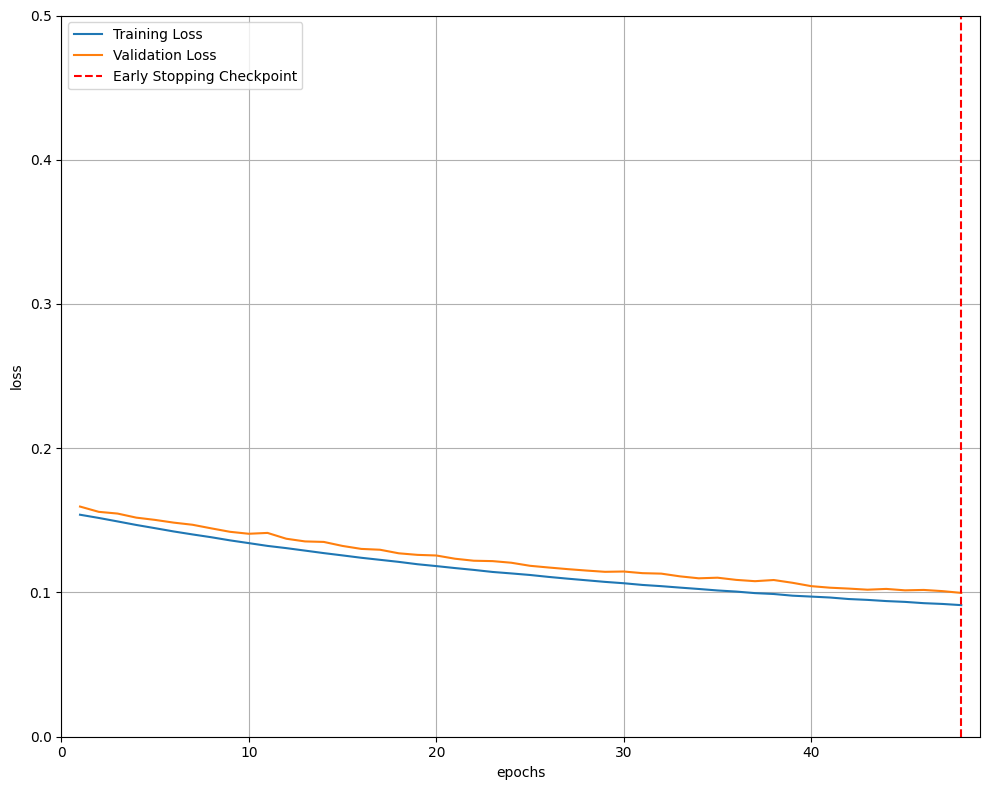

In [29]:
plot_loss(train_loss=train_loss,valid_loss=valid_loss)

### Evaluation

In [30]:
acc, precision, recall, f1, cm, loss = check_accuracy(model=model, device=device,test_loader=test_loader, criterion=criterion)

In [25]:
print(f'Accuracy: {acc * 100:.2f}%')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

Accuracy: 97.39%
Precision: 0.9738, Recall: 0.9737, F1-Score: 0.9737


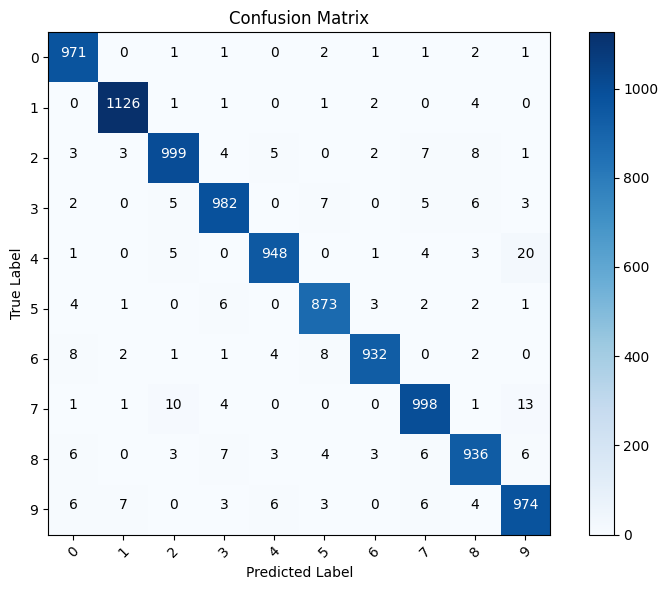

In [31]:
plot_confusion_matrix(cm)